In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings

from catboost import CatBoostClassifier
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima.model import ARIMA

In [2]:
warnings.filterwarnings('ignore')

In [3]:
sns.set_theme()
sns.set_palette('Paired')

In [4]:
os.listdir('data')

['Dewas_NDVI.csv',
 'Dewas_points.csv',
 'Kaithal_NDVI.csv',
 'Kaithal_points.csv',
 'Karnal_NDVI.csv',
 'Karnal_points.csv']

In [5]:
districts = ['Dewas', 'Kaithal', 'Karnal']

In [6]:
data = dict(zip(districts, [{}, {}, {}]))
for district in districts:
    points = pd.read_csv(f'data/{district}_points.csv')
    ndvi = pd.read_csv(f'data/{district}_NDVI.csv')
    data[district]['points'] = points
    data[district]['NDVI'] = ndvi
    data[district]['merged'] = points.merge(ndvi,
                                            left_on='gfid',
                                            right_on='gfid')

In [7]:
data['Dewas']['merged'].head()

,gfid,state,district,village,lon,lat,wheat,datenum,date,ndvi
0,72001,Madhya Pradesh,Dewas,VijayaganjMandi,75.96199,23.218479,0,0,2020-10-20,0.186
1,72001,Madhya Pradesh,Dewas,VijayaganjMandi,75.96199,23.218479,0,1,2020-10-21,0.184
2,72001,Madhya Pradesh,Dewas,VijayaganjMandi,75.96199,23.218479,0,2,2020-10-22,0.183
3,72001,Madhya Pradesh,Dewas,VijayaganjMandi,75.96199,23.218479,0,3,2020-10-23,0.182
4,72001,Madhya Pradesh,Dewas,VijayaganjMandi,75.96199,23.218479,0,4,2020-10-24,0.181


In [8]:
dewas_avg = data['Dewas']['merged'].groupby('date').agg({'ndvi': 'mean'})
karnal_avg = data['Karnal']['merged'].groupby('date').agg({'ndvi': 'mean'})
kaithal_avg = data['Kaithal']['merged'].groupby('date').agg({'ndvi': 'mean'})

# Dewas

In [9]:
sm.tsa.adfuller(dewas_avg, 2)

(-2.6969944006215316,
 0.07455981464921177,
 2,
 200,
 {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225},
 -2446.811841581606)

In [10]:
sm.tsa.adfuller(dewas_avg, 1)

(-5.77413598650406,
 5.307746836798032e-07,
 1,
 201,
 {'1%': -3.4633090972761744,
  '5%': -2.876029332045744,
  '10%': -2.5744932593252643},
 -2382.894825735602)

In [11]:
sm.tsa.adfuller(dewas_avg)

(-1.689024461365378,
 0.4367760918393596,
 3,
 199,
 {'1%': -3.4636447617687436,
  '5%': -2.8761761179270766,
  '10%': -2.57457158581854},
 -2305.0285988049677)

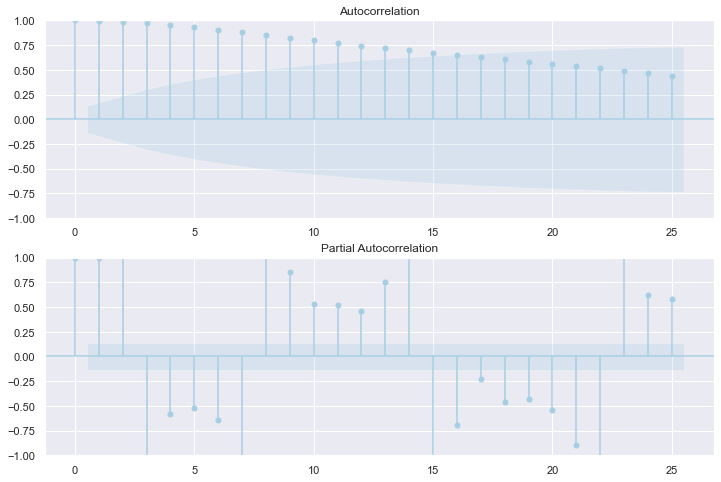

In [12]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(
    dewas_avg.diff(periods=1).dropna().values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(
    dewas_avg.diff(periods=1).dropna().values.squeeze(), lags=25, ax=ax2)

In [13]:
arima = ARIMA(dewas_avg, order=(5, 1, 5)).fit()

In [14]:
arima.params

ar.L1    -8.610992e-01
ar.L2    -2.231459e-01
ar.L3     5.812678e-01
ar.L4     9.009038e-01
ar.L5     5.928267e-01
ma.L1     2.088232e+00
ma.L2     2.793424e+00
ma.L3     2.575692e+00
ma.L4     1.615284e+00
ma.L5     5.863422e-01
sigma2    3.424780e-07
dtype: float64

In [15]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ndvi   No. Observations:                  203
Model:                 ARIMA(5, 1, 5)   Log Likelihood                1212.233
Date:                Mon, 13 Jun 2022   AIC                          -2402.465
Time:                        16:17:14   BIC                          -2366.074
Sample:                    10-20-2020   HQIC                         -2387.741
                         - 05-10-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8611      0.078    -11.050      0.000      -1.014      -0.708
ar.L2         -0.2231      0.092     -2.415      0.016      -0.404      -0.042
ar.L3          0.5813      0.082      7.060      0.000       0.420       0.743
ar.L4          0.9009      0.099      9.060      0.000       0.706       1.096
ar.L5          0.5928      0.105      5.629      0.000       0.386       0.799
ma.L1          2.0882      0.085     24.654      0.000       1.922       2.254
ma.L2          2.7934      0.133     21.031      0.000       2.533       3.054
ma.L3          2.5757      0.158     16.302      0.000       2.266       2.885
ma.L4          1.6153      0.110     14.739      0.000       1.400       1.830
ma.L5          0.5863      0.046     12.802      0.000       0.497       0.676
sigma2      3.425e-07   2.23e-08     15.365      0.000    2.99e-07    3.86e-07
===================================================================================
Ljung-Box (L1) (Q):                   9.64   Jarque-Bera (JB):               594.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
stats.normaltest(arima.resid.values)

NormaltestResult(statistic=450.54679600557665, pvalue=1.4621984789488071e-98)

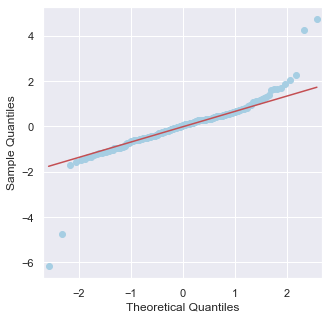

In [17]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
fig = qqplot(arima.resid.values[1:-1], line="q", ax=ax, fit=True)

In [18]:
q_test = sm.tsa.stattools.acf(arima.resid, qstat=True)
print(pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]}))

      Q-stat   p-value
0   0.052775  0.818302
1   0.053287  0.973708
2   0.054251  0.996694
3   0.054509  0.999635
4   0.054776  0.999963
5   0.058802  0.999996
6   0.059439  1.000000
7   0.059872  1.000000
8   0.060499  1.000000
9   0.060540  1.000000
10  0.060678  1.000000
11  0.060723  1.000000
12  0.060957  1.000000
13  0.061898  1.000000
14  0.061925  1.000000
15  0.095970  1.000000
16  0.133616  1.000000
17  0.135004  1.000000
18  0.141736  1.000000
19  0.143148  1.000000
20  0.143153  1.000000
21  0.145162  1.000000
22  0.147274  1.000000


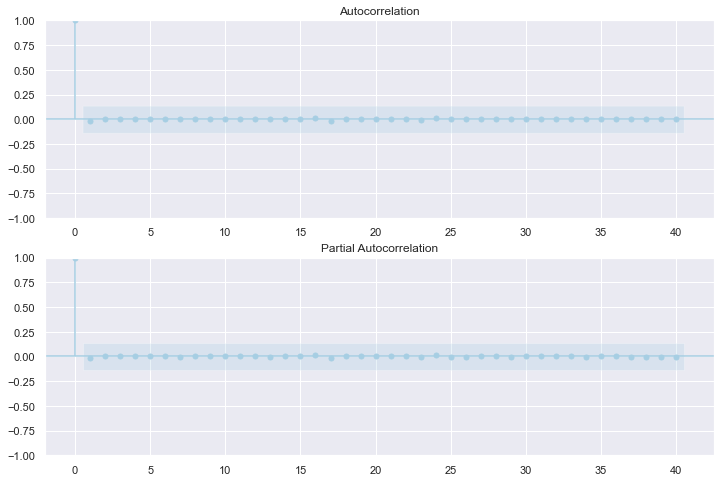

In [19]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima.resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima.resid.values, lags=40, ax=ax2)

# Kaithal

In [20]:
sm.tsa.adfuller(kaithal_avg, 2)

(-2.654937472246509,
 0.08216587616641641,
 2,
 200,
 {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225},
 -2157.158323358947)

In [21]:
sm.tsa.adfuller(kaithal_avg, 1)

(-5.51232291564173,
 1.9595299038324714e-06,
 1,
 201,
 {'1%': -3.4633090972761744,
  '5%': -2.876029332045744,
  '10%': -2.5744932593252643},
 -2107.205940141206)

In [22]:
sm.tsa.adfuller(kaithal_avg, )

(-2.828055541120112,
 0.05437663787757806,
 11,
 191,
 {'1%': -3.465058702600837,
  '5%': -2.8767942675230356,
  '10%': -2.5749014492475535},
 -2104.495454232945)

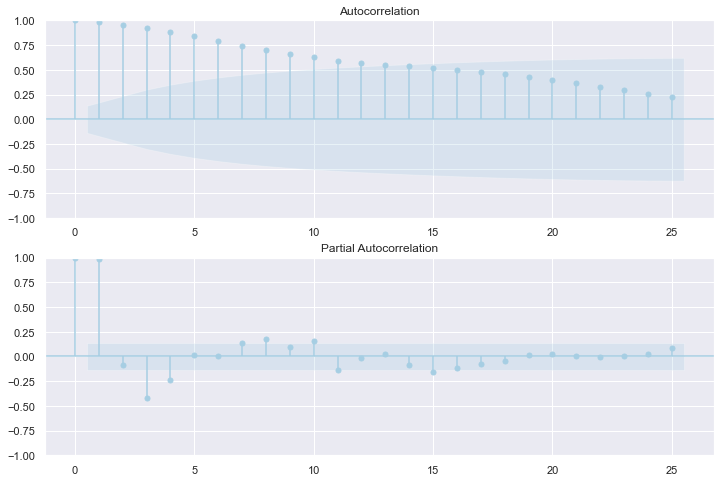

In [23]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(kaithal_avg.diff(1).dropna().values.squeeze(),
                               lags=25,
                               ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(kaithal_avg.diff(1).dropna().values.squeeze(),
                                lags=25,
                                ax=ax2)

In [24]:
arima = ARIMA(kaithal_avg, order=(1, 1, 5)).fit()

In [25]:
arima.params

ar.L1     0.963972
ma.L1     0.493424
ma.L2     0.640992
ma.L3     0.529514
ma.L4     0.592428
ma.L5     0.541466
sigma2    0.000001
dtype: float64

In [26]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ndvi   No. Observations:                  203
Model:                 ARIMA(1, 1, 5)   Log Likelihood                1092.731
Date:                Mon, 13 Jun 2022   AIC                          -2171.462
Time:                        16:17:15   BIC                          -2148.304
Sample:                    10-20-2020   HQIC                         -2162.092
                         - 05-10-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9640      0.040     24.248      0.000       0.886       1.042
ma.L1          0.4934      0.094      5.276      0.000       0.310       0.677
ma.L2          0.6410      0.075      8.593      0.000       0.495       0.787
ma.L3          0.5295      0.076      6.923      0.000       0.380       0.679
ma.L4          0.5924      0.060      9.798      0.000       0.474       0.711
ma.L5          0.5415      0.116      4.678      0.000       0.315       0.768
sigma2      1.124e-06    8.9e-08     12.636      0.000     9.5e-07     1.3e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             25650.61
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              35.02   Skew:                             4.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
stats.normaltest(arima.resid.values)

NormaltestResult(statistic=449.96694216757925, pvalue=1.9539794362244418e-98)

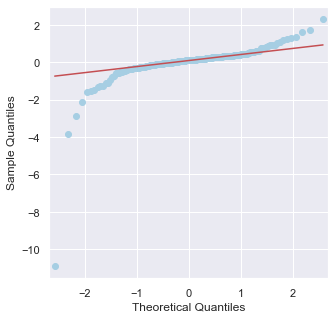

In [28]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
fig = qqplot(arima.resid.values[1:-1], line="q", ax=ax, fit=True)

In [29]:
q_test = sm.tsa.stattools.acf(arima.resid, qstat=True)
print(pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]}))

      Q-stat   p-value
0   0.266884  0.605430
1   0.267482  0.874817
2   0.267492  0.966022
3   0.267525  0.991813
4   0.267589  0.998209
5   0.267738  0.999638
6   0.267741  0.999932
7   0.268034  0.999988
8   0.268048  0.999998
9   0.268054  1.000000
10  0.268054  1.000000
11  0.268062  1.000000
12  0.268177  1.000000
13  0.268263  1.000000
14  0.268279  1.000000
15  0.268303  1.000000
16  0.268426  1.000000
17  0.268515  1.000000
18  0.268686  1.000000
19  0.268705  1.000000
20  0.268705  1.000000
21  0.268705  1.000000
22  0.268707  1.000000


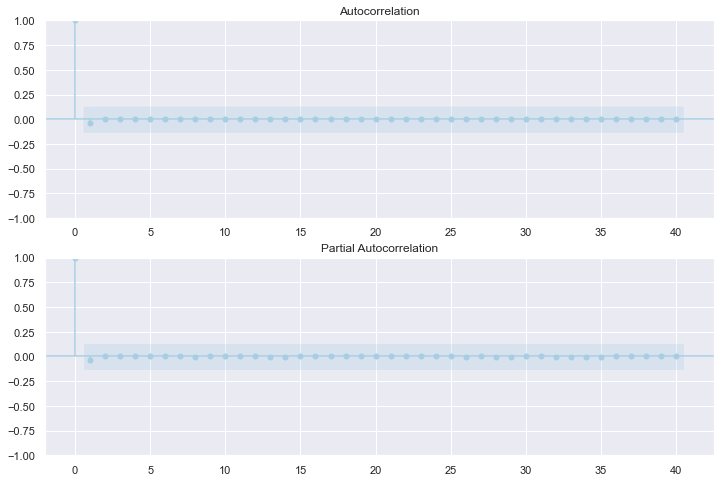

In [30]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima.resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima.resid.values, lags=40, ax=ax2)

# Karnal

In [31]:
sm.tsa.adfuller(karnal_avg, 2)

(-4.219124419763842,
 0.0006114697063027501,
 1,
 201,
 {'1%': -3.4633090972761744,
  '5%': -2.876029332045744,
  '10%': -2.5744932593252643},
 -1975.8910322271295)

In [32]:
sm.tsa.adfuller(karnal_avg, 1)

(-4.219124419763842,
 0.0006114697063027501,
 1,
 201,
 {'1%': -3.4633090972761744,
  '5%': -2.876029332045744,
  '10%': -2.5744932593252643},
 -1986.6979896061616)

In [33]:
sm.tsa.adfuller(karnal_avg)

(-2.898836743493376,
 0.04548343569368321,
 13,
 189,
 {'1%': -3.4654311561944873,
  '5%': -2.8769570530458792,
  '10%': -2.574988319755886},
 -2046.1607199948676)

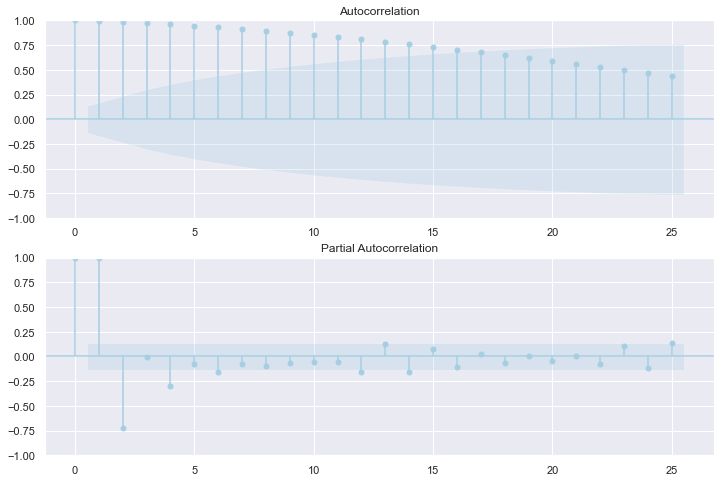

In [34]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(karnal_avg.dropna().values.squeeze(),
                               lags=25,
                               ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(karnal_avg.dropna().values.squeeze(),
                                lags=25,
                                ax=ax2)

In [35]:
arima = ARIMA(karnal_avg, order=(1, 0, 5)).fit()

In [36]:
arima.params

const     0.369970
ar.L1     0.996280
ma.L1     1.469795
ma.L2     2.008296
ma.L3     1.879304
ma.L4     1.458710
ma.L5     0.786150
sigma2    0.000003
dtype: float64

In [37]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ndvi   No. Observations:                  203
Model:                 ARIMA(1, 0, 5)   Log Likelihood                 989.232
Date:                Mon, 13 Jun 2022   AIC                          -1962.464
Time:                        16:17:16   BIC                          -1935.959
Sample:                    10-20-2020   HQIC                         -1951.741
                         - 05-10-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3700      0.344      1.077      0.282      -0.303       1.043
ar.L1          0.9963      0.006    169.567      0.000       0.985       1.008
ma.L1          1.4698      0.051     28.801      0.000       1.370       1.570
ma.L2          2.0083      0.067     29.835      0.000       1.876       2.140
ma.L3          1.8793      0.102     18.499      0.000       1.680       2.078
ma.L4          1.4587      0.072     20.151      0.000       1.317       1.601
ma.L5          0.7861      0.072     10.920      0.000       0.645       0.927
sigma2      3.171e-06   2.08e-07     15.238      0.000    2.76e-06    3.58e-06
===================================================================================
Ljung-Box (L1) (Q):                   7.11   Jarque-Bera (JB):              9019.18
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               8.78   Skew:                             3.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
stats.normaltest(arima.resid.values)

NormaltestResult(statistic=327.23157528867375, pvalue=8.761254051220596e-72)

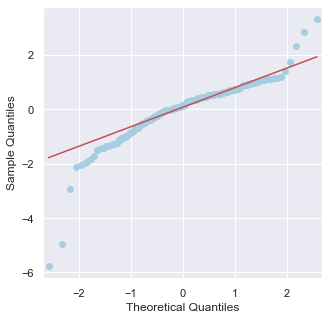

In [39]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
fig = qqplot(arima.resid.values[1:-1], line="q", ax=ax, fit=True)

In [40]:
q_test = sm.tsa.stattools.acf(arima.resid, qstat=True)
print(pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]}))

       Q-stat   p-value
0    9.097581  0.002559
1   11.095806  0.003896
2   13.336379  0.003963
3   15.866401  0.003204
4   17.142648  0.004237
5   19.084346  0.004024
6   20.523574  0.004543
7   22.251957  0.004470
8   22.323449  0.007908
9   24.719622  0.005903
10  25.241558  0.008402
11  26.085915  0.010437
12  26.545077  0.014351
13  27.277774  0.017713
14  27.602537  0.024194
15  27.804541  0.033361
16  28.218863  0.042445
17  28.558710  0.054046
18  28.560192  0.073225
19  28.812797  0.091511
20  28.819774  0.118396
21  28.884040  0.148201
22  28.891753  0.183926


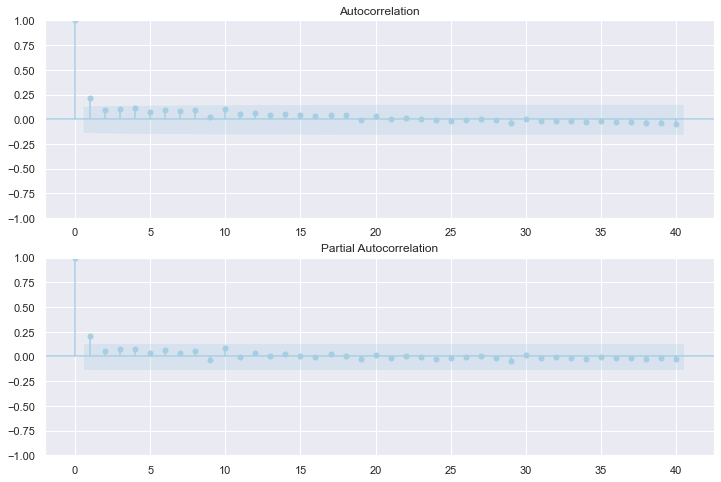

In [41]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima.resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima.resid.values, lags=40, ax=ax2)